### Import libraries

In [232]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Import data

In [233]:
df = pd.read_csv('./datasets/Telco_customer_churn.csv')

In [234]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### Cleaning data

Remove the last four variables due to contain exit interview information and shoudn't be used for inference.

In [235]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], axis=1, inplace=True)

In [236]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


We can see that some columns only contain a single value and will not be useful for this classification task. 

In [237]:
drop_list = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        drop_list.append(col)
        print(f"{col}: {df[col].unique()}")
print(f'\nColums to drop: {drop_list}')

Count: [1]
Country: ['United States']
State: ['California']

Colums to drop: ['Count', 'Country', 'State']


In [238]:
df.drop(drop_list, axis=1, inplace=True)

In [239]:
df.head()

,CustomerID,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


We need to remove `CustomerID` because it's different in all cases, it's useless for classification. In addition, it's necessary remove `Lat Long` due to there are separate columns `Latitude` and `Longitude`.

In [240]:
df.drop(['CustomerID', 'Lat Long'], axis=1, inplace=True)

In [241]:
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


### Missing Data: Identification and Adjustment

One characteristic of XGBost is that it has default behavior for missing data, we just need to identify missing values and set them to 0.

In [242]:
df.dtypes

City                  object
Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Value            int64
dtype: object

A lot of columns are object type, which is normal because there are many text answers (`Yes` and `No`), however this is not the case for all columns. We can see `Total_Charges` contain numbers, not text, but the object datatype suggest that it contains more than just numbers. In this case, there are some missing values represented as white spaces.

Note: In practice, we need to check every column.

In [243]:
len(df.loc[df['Total Charges'].str.contains(' ')])

11

These persons with `Total Charges == '0'` have just signe up, because `Tenure Months` and `Churn Value` is 0.

In [244]:
df.loc[df['Total Charges'].str.contains(' ')]

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
2234,San Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


We can remove these 11 people, but in this opportunity we will try setting `Total Charges` to 0.

In [245]:
df.loc[df['Total Charges'] == ' ', 'Total Charges'] = 0

Now if we look for everyone who had `Tenure Months` set to 0. It works!

In [246]:
df.loc[df['Tenure Months'] == 0]

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
2234,San Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


At this point `Total Charges` still has the object type, but `XGBoost` only allows `int`, `float` or `boolean` types. So, we need to fix this by converting it with the function ---> `to_numeric()`.

In [247]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'])

In [248]:
df.dtypes

City                  object
Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges        float64
Churn Value            int64
dtype: object

### Tree Grapgh Constrain

It's important to know we need to replace the white spaces in the data of some columns with underscore character `"_"`, these white spaces are not a problem for `XGBoost/classification` but if we want to draw a `tree` it's necessary.

As you can see, there are several columns that contain white spaces in their data.

In [249]:
for col in df.columns:
    if df[col].dtype == 'O' and True in df[col].str.contains(' ').to_numpy():
        print(f"{col}: \n{df[col].unique()}\n")

City: 
['Los Angeles' 'Beverly Hills' 'Huntington Park' ... 'Standish' 'Tulelake'
 'Olympic Valley']

Multiple Lines: 
['No' 'Yes' 'No phone service']

Internet Service: 
['DSL' 'Fiber optic' 'No']

Online Security: 
['Yes' 'No' 'No internet service']

Online Backup: 
['Yes' 'No' 'No internet service']

Device Protection: 
['No' 'Yes' 'No internet service']

Tech Support: 
['No' 'Yes' 'No internet service']

Streaming TV: 
['No' 'Yes' 'No internet service']

Streaming Movies: 
['No' 'Yes' 'No internet service']

Contract: 
['Month-to-month' 'Two year' 'One year']

Payment Method: 
['Mailed check' 'Electronic check' 'Bank transfer (automatic)'
 'Credit card (automatic)']



We already have dealt with the missing data, now we can replace all of the other white spaces with underscores (`"_"`), starting with the column names.

In [250]:
df.columns = df.columns.str.replace(' ', '_')

In [251]:
df.columns.unique()

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

In [252]:
df.replace(' ', '_', regex=True, inplace=True)

In [253]:
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


### Format Data (Spliting)

Split the data into two parts:

* The columns of data that we will use to make classifications (capital `X`).
* The column of data that we want to predict (lower case `y`).

Use the fuction `copy()` to ensure that the original data from `df`.

In [254]:
X = df.drop('Churn_Value', axis=1).copy()

In [255]:
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [256]:
y = df['Churn_Value'].copy()

In [257]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

### Format Data (One-Hot Encoding)

XGBoost and a lot machine learning algorithms natively supports continuos data, but they don't natively support categorical data. Therefore, we will use the One-Hot Encoding technique to convert a column of categorical data into multiples columns of binary values.

In [258]:
X.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
dtype: object

In [259]:
dummies_list = []
for col in df.columns:
    if df[col].dtype == 'O':
        dummies_list.append(col)
print(dummies_list)

['City', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method']


In [260]:
X_encoded = pd.get_dummies(X, columns=dummies_list)

In [261]:
X_encoded.head(5)

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


Verify that `y` only contains `1s` and `0s`

In [263]:
y.unique()

array([1, 0], dtype=int64)

### Build XGBoost Model (Preliminary)

In [264]:
sum(y)/len(y)

0.2653698707936959

As we can see the data is imbalanced, only `27%` of the people in the dataset left the company. Because of this, we will the data into training and testing using `stratification` in order to mantein the same percentage of people who left the company in both the train set and test set.

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

Verify if `stratify` have worked.

In [266]:
sum(y_train)/len(y_train)

0.2654297614539947

In [267]:
sum(y_test)/len(y_test)

0.26519023282226006

We will use `early stopping` to stop building trees when they no longer improve the situation.

In [268]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", 
                            missing=1, 
                            seed=42,
                            early_stopping_rounds=10, 
                            eval_metric="aucpr")

In [269]:
xgb_clf.fit(X_train, 
            y_train,
            verbose=True,
            #early_stopping_rounds=10, 
            #eval_metric="aucpr", 
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64404
[2]	validation_0-aucpr:0.65124
[3]	validation_0-aucpr:0.65311
[4]	validation_0-aucpr:0.65513
[5]	validation_0-aucpr:0.65397
[6]	validation_0-aucpr:0.64818
[7]	validation_0-aucpr:0.64908
[8]	validation_0-aucpr:0.65365
[9]	validation_0-aucpr:0.65074
[10]	validation_0-aucpr:0.65010
[11]	validation_0-aucpr:0.65012
[12]	validation_0-aucpr:0.65120
[13]	validation_0-aucpr:0.65150
[14]	validation_0-aucpr:0.65163


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=1, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Let's see how it performs on the `test dataset`. 

In [270]:
y_pred = xgb_clf.predict(X_test)

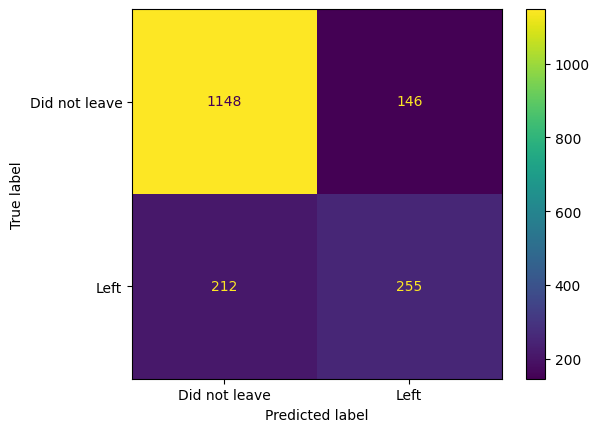

In [271]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did not leave", "Left"])
disp.plot()

With the confusion matrix results we can see that `1294` of the people `didn't leave` and `1148` were correctly classified, representing a `89%`. In the other side, `467` of the people `left` the company, `255` were correctly classified, representing a `54%`. 

Up to this point, the XGBoost model wasn't good and part of the problem is that our data is imbalanced. Due to people leaving costs a lot of money for the company we would put more attention on the people who leave the company.

Now, we will try to improve predictions using Cross Validation to optimize parameters.

